In [23]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

In [24]:
import random
import sklearn
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt


#Importing Datasets

TextDataset is Described in Section 3.3 of Assignment 2

In [25]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "/content/"# set path to your dataset directory
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

In [26]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=100)    # embedding size = 50

.vector_cache/glove.6B.zip: 862MB [02:47, 5.15MB/s]                           
100%|█████████▉| 399999/400000 [00:19<00:00, 20487.40it/s]


In [27]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [32]:
torch.manual_seed(2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
#glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# 3.3.2
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "val")
test_dataset = TextDataset(glove, "test")
overfit_dataset= TextDataset(glove, "overfit")
    
# 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))
validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))




Using device: cpu


#Creating baseline model

In [28]:
class BaselineModel(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        # initialize word vectors to random numbers 
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.out=torch.nn.Linear(100,1)
        #TO DO
        
        # prediction function takes embedding as input, and predicts which word in vocabulary as output

        #TO DO
        
    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        #TO DO
        e=0
        for item in x:
          e+=self.embedding(item)
        e/= len(x)
        logits=self.out(e).squeeze()
        #out=torch.nn.functional.sigmoid(logits).squeeze()
        
        return logits

#testing baseline with overfit

In [29]:
model1=BaselineModel(glove)

In [30]:
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_losses=[]
val_losses=[]
train_acc_arr=[]
val_acc_arr=[]

epoch= 0
train loss= 0.18663447499275207
train_acc for epoch 0.38
validation error= 0.17188145902007818
val_acc for epoch 0.568125
epoch= 1
train loss= 0.18024981260299683
train_acc for epoch 0.5
validation error= 0.17149117842316627
val_acc for epoch 0.59375
epoch= 2
train loss= 0.17892030477523804
train_acc for epoch 0.54
validation error= 0.17113009452819825
val_acc for epoch 0.59375
epoch= 3
train loss= 0.17811485171318053
train_acc for epoch 0.56
validation error= 0.17078143905848264
val_acc for epoch 0.5975
epoch= 4
train loss= 0.1774480426311493
train_acc for epoch 0.6
validation error= 0.17043924473226071
val_acc for epoch 0.5875
epoch= 5
train loss= 0.17682481646537782
train_acc for epoch 0.62
validation error= 0.17009939454495906
val_acc for epoch 0.580625
epoch= 6
train loss= 0.17621618628501892
train_acc for epoch 0.64
validation error= 0.16975966803729534
val_acc for epoch 0.58375
epoch= 7
train loss= 0.17561283588409424
train_acc for epoch 0.66
validation error= 0.1694191

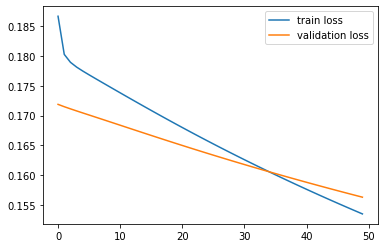

In [33]:
for epoch in range(50):  # loop over the dataset multiple times

    train_loss = 0.0
    train_acc=0
    val_acc=0
    model1.train()
    print('epoch=', epoch)
    
    for inputs, labels in overfit_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        train_acc+=torch.sum(((outputs>0)== labels)[:].int()).item()
    train_loss=train_loss/len(overfit_dataset)
    train_losses.append(train_loss)
    print('train loss=',train_loss)
    train_acc=train_acc/len(overfit_dataset)
    train_acc_arr.append(train_acc)
    print('train_acc for epoch',train_acc)


    val_loss=0.0
    model1.eval()
    for inputs, labels in validation_dataloader:

      pred=model1(inputs)
      loss = loss_func(pred, labels.float())
      val_loss+= loss.item()
      val_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
    val_loss=val_loss/len(val_dataset)
    val_losses.append(val_loss)
    print('validation error=',val_loss)
    val_acc=val_acc/len(val_dataset)
    val_acc_arr.append(val_acc)
    print('val_acc for epoch',val_acc)


print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

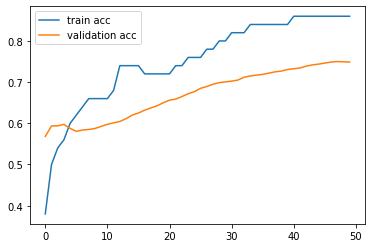

In [34]:
#accuracy plots
plt.plot(train_acc_arr, label='train acc')
plt.plot(val_acc_arr, label='validation acc')
plt.legend()
plt.show()

In [35]:
#testing
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs)
  loss = loss_func(pred, labels.float())
  test_loss+= loss.item()
  test_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

test error= 0.15559787219762802
test_accuracy 0.743


In [ ]:
torch.save(model1.state_dict(), 'overfit model baseline.pt')

# training baseline with train dataset

In [ ]:
model1=BaselineModel(glove)

In [ ]:
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_losses=[]
val_losses=[]
train_acc_arr=[]
val_acc_arr=[]

epoch= 0
train loss= 0.14943992911372334
train_acc 0.7753125
validation error= 0.13392655931413175
val_acc for epoch 0.841875
epoch= 1
train loss= 0.1215666953008622
train_acc 0.85484375
validation error= 0.11558242392726242
val_acc for epoch 0.850625
epoch= 2
train loss= 0.10722795274108649
train_acc 0.86296875
validation error= 0.1053995705768466
val_acc for epoch 0.854375
epoch= 3
train loss= 0.09868816045927815
train_acc 0.8684375
validation error= 0.09907167823286728
val_acc for epoch 0.858125
epoch= 4
train loss= 0.09305756079556886
train_acc 0.87140625
validation error= 0.0948055042582564
val_acc for epoch 0.859375
epoch= 5
train loss= 0.08906112083757761
train_acc 0.8734375
validation error= 0.09174836033722386
val_acc for epoch 0.863125
epoch= 6
train loss= 0.08606440259085503
train_acc 0.87484375
validation error= 0.08945376111427322
val_acc for epoch 0.864375
epoch= 7
train loss= 0.08372219369455706
train_acc 0.8771875
validation error= 0.08766910371603444
val_acc for epoch 

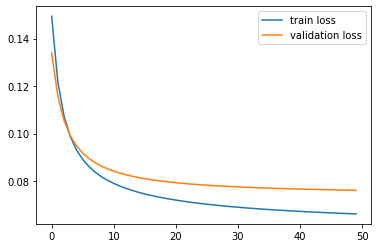

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times

    train_loss = 0.0
    val_loss=0
    train_acc=0
    val_acc=0
    model1.train()
    print('epoch=', epoch)
    
    for inputs, labels in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        train_acc+=torch.sum(((outputs>0)== labels)[:].int()).item()
    train_loss=train_loss/len(train_dataset)
    train_losses.append(train_loss)
    print('train loss=',train_loss)
    train_acc=train_acc/len(train_dataset)
    train_acc_arr.append(train_acc)
    print('train_acc',train_acc)


    model1.eval()
    for inputs, labels in validation_dataloader:

      pred=model1(inputs)
      loss = loss_func(pred, labels.float())
      val_loss+= loss.item()
      val_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
    val_loss=val_loss/len(val_dataset)
    val_losses.append(val_loss)
    print('validation error=',val_loss)
    val_acc=val_acc/len(val_dataset)
    val_acc_arr.append(val_acc)
    print('val_acc for epoch',val_acc)


print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

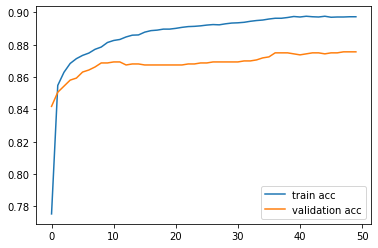

In [ ]:
plt.plot(train_acc_arr, label='train acc')
plt.plot(val_acc_arr, label='validation acc')
plt.legend()
plt.show()

In [ ]:
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs)
  loss = loss_func(pred, labels.float())
  test_loss+= loss.item()
  test_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

test error= 0.06724662682181225
test_accuracy 0.9005


In [ ]:
torch.save(model1.state_dict(), 'model baseline.pt')

# extracting meaning from parameters

In [ ]:
model = BaselineModel(glove)
model.load_state_dict(torch.load('/content/model baseline.pt'))
model.eval()

BaselineModel(
  (embedding): Embedding(400000, 100)
  (out): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
def print_closest_cosine_words(vec, n=5):
  dists = torch.cosine_similarity(glove.vectors.unsqueeze(0), vec.unsqueeze(0), dim=2).squeeze()
  dist_sort=torch.argsort(dists,descending=True)
  for idx in dist_sort[1:n+1]:
    print(glove.itos[idx], "\t%5.2f" % dists[idx])

In [ ]:
model.out.weight.squeeze()

tensor([-2.7072e+00,  2.1354e+00,  7.7290e-01, -4.3207e-01, -2.5790e+00,
        -4.8087e-01, -1.5702e-01, -7.6742e-01, -4.3039e-01,  9.2636e-02,
         2.3552e-01, -1.9167e+00, -2.6446e+00, -6.4450e+00,  2.6522e+00,
         1.8428e+00, -3.2117e+00,  9.4824e-01,  4.3358e+00,  1.9550e+00,
         1.5205e+00,  1.4541e+00, -1.2447e+00, -3.3539e+00,  1.7275e+00,
        -8.7081e-01, -2.1097e+00,  1.5374e+00, -1.6274e+00, -5.2319e+00,
         3.2859e+00, -1.3128e-01,  7.8117e-01, -4.8416e-01,  4.9465e-01,
         3.1623e+00,  2.2069e+00,  1.0522e+00, -2.5236e+00,  9.6323e-01,
         2.3934e+00,  3.4624e-01, -2.9854e+00,  2.1311e+00,  4.1521e-01,
        -3.1147e-01,  2.7021e+00, -1.8836e+00, -2.7530e+00, -1.6420e+00,
         2.0561e+00, -1.9593e+00,  3.0713e-01, -5.6122e-01, -1.2240e+00,
        -1.4864e-01,  1.4383e+00,  4.8924e-01,  3.1374e-01, -2.0148e+00,
        -1.9508e-01,  9.4889e-01,  7.7430e-02,  1.6233e+00, -3.0609e-01,
        -3.6448e+00,  3.6659e-01,  1.2343e-01, -3.3

In [ ]:
print_closest_cosine_words(model.out.weight.squeeze(),20)

flattering 	 0.53
pleasing 	 0.52
watchable 	 0.52
campy 	 0.51
underwhelming 	 0.51
verbiage 	 0.51
emptier 	 0.49
simplistic 	 0.49
appetizing 	 0.49
funnily 	 0.49
laughable 	 0.48
tepid 	 0.48
visuals 	 0.48
goofier 	 0.48
mesmerizing 	 0.48
nuanced 	 0.48
laudatory 	 0.47
glib 	 0.47
befuddling 	 0.47
forgettable 	 0.47
